# Importe

In [1]:
# Data
import pandas as pd
import sqlite3
import urllib.request
import re
import locale

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from spacy import displacy
!python -m spacy download en_core_web_sm

# PDF
import pdfplumber
import glob
import os
import sys


     ---------------------------------------- 12.8/12.8 MB 6.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Load Data

In [2]:
# df_firms = pd.read_excel("C:\\Users\\lange\\OneDrive\\Dokumente\\Studium\\06_Abschlussarbeiten\\Seminar\\UN_HRB.xlsx")
# df_firms.head(2)

DB_CONNECT = 'C:/Users/lange/OneDrive/Dokumente/Studium/06_Abschlussarbeiten/Seminar/03_Data/hareg.db'
engine = sqlite3.connect(DB_CONNECT)
sql = '''SELECT* FROM df_firms'''
df_firms = pd.read_sql(sql, engine)
df_firms

,name,regricht,regart,regnum,url,label,text,gegenstand,capital,website,zeichen
0,AUDI AG,Ingolstadt,HRB,1,https://www.audi.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,"Entwicklung, Herstellung und Vertrieb von Kraf...","110080000,00","b'<!DOCTYPE html>\n<html lang=""de"" class=""nm-c...",179
1,Volkswagen AG,Wolfsburg,HRB,100484,https://www.volkswagen.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Gegenstand des Unternehmens ist die Herstellun...,"1283315873,28","b'\n\n\n\n<!DOCTYPE html>\n<html lang=""de"" dir...",551
2,ŠKODA AUTO Deutschland GmbH,Darmstadt,HRB,5242,https://www.skoda-auto.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Ist der Import und der Vertrieb von Fahrzeugen...,"2045200,00","b'<!DOCTYPE html>\n<html dir=""ltr"" lang=""de-D...",155
3,Tesla Germany GmbH,Berlin (Charlottenburg),HRB,235261,https://www.tesla.com/de_de/,Automotive,\n- Wiedergabe des aktuellen Registerinhalts -...,"Herstellung, Import, Vertrieb, Verkauf, Wartun...","25000,00","b'<!DOCTYPE html><html lang=""de-DE"" dir=""ltr"" ...",1074
4,BMW AG,München,HRB,42243,https://www.bmw.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Herstellung und Vertrieb von Motoren und damit...,"661399500,00","b'<!DOCTYPE HTML><html lang=""de-DE"" dir=""ltr"" ...",248
...,...,...,...,...,...,...,...,...,...,...,...
109,METRO AG,Düsseldorf,HRB,79055,https://www.metroag.de/de,Wholesale,\nHandelsregister B des Abteilung B Nummer der...,Die Leitung und Förderung von Handels- und Die...,"363097253,00","b'\xef\xbb\xbf<!DOCTYPE html>\r\n<html xmlns=""...",785
110,BayWa AG,München,HRB,4921,https://www.baywa.com/,Wholesale,\nHandelsregister B des Abteilung B Nummer der...,Die Gesellschaft leitet eine internationale Un...,"91807715,84","b'<!doctype html>\n\n\n\n\n\n\n\n<html lang=""d...",1151
111,Brenntag GmbH,Duisburg,HRB,8894,https://www.brenntag.com/de-de/,Wholesale,\nHandelsregister B des Abteilung B Nummer der...,der Handel mit chemischen Erzeugnissen aller A...,"3000000,00",b'<!doctype html>\n<html data-n-head-ssr lang=...,528
112,Klöckner & Co SE,Duisburg,HRB,20486,https://www.kloeckner.com/de,Wholesale,\nHandelsregister B des Abteilung B Nummer der...,Gegenstand des Unternehmens ist (a) die Distri...,"249375000,00","b'<!doctype html>\n<html lang=""de"">\n<head>\n\...",342


# Einlesen PDF

In [3]:
paths = glob.glob("C:\\Users\\lange\\OneDrive\\Dokumente\\Studium\\06_Abschlussarbeiten\\Seminar\\02_Download\\HRB_data\\*")
print("first file: ", paths[0], "\nlen: ", len(paths))

first file:  C:\Users\lange\OneDrive\Dokumente\Studium\06_Abschlussarbeiten\Seminar\02_Download\HRB_data\BE-Berlin_(Charlottenburg)_HRB_141365+AD-20221113194718.pdf 
len:  114


In [4]:
# prepare df_firms
df_firms = df_firms.apply(lambda x: x.apply(str) if x.dtype == 'object' else x)
df_firms = df_firms.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

In [5]:
def get_regs_from_path(path):
    filename = os.path.basename(path)
    filename = filename.split(sep = "+")
    filename = filename[0].split(sep = "-")
    filename = filename[1].split(sep = "_")

    if len(filename) == 3:
        regricht = filename[0]
        regart = filename[1]
        regnum = filename[2]
    elif len(filename) == 4:
        regricht = filename[0] + " " + filename[1]
        regart = filename[2]
        regnum = filename[3]
    elif len(filename) == 5:
        regricht = filename[0] + " " + filename[1] + " " + filename[2]
        regart = filename[3]
        regnum = filename[4]
    else:
        # wird erstmal nicht abgefangen
        raise ValueError("Error while getting regs from filename", filename)
        
    return regricht, regart, regnum

In [6]:
def plumb_pdf(path):
    with pdfplumber.open(path) as pdf:
        
        # first_page = pdf.pages[0]
        # text = first_page.extract_text()
        
        text = ''
        for pdf_page in pdf.pages:
            single_page_text = pdf_page.extract_text()
            text = text + '\n' + single_page_text
        
        # erhalte regricht, regart, regnum, und text aus dem PDF       
        regricht, regart, regnum = get_regs_from_path(path=path)
        print("regricht: {}\nregart: {}\nregnum: {}\ntext:\n{}".format(regricht, regart, regnum, text))
        
        # zuordnen des Textes aus dem PDF zum Unternehmen
        i = df_firms.index[(df_firms['regricht'] == regricht) & (df_firms['regart'] == regart) & (df_firms['regnum'] == regnum)]
        df_firms.loc[i, "text"] = text
        
        return text

In [7]:
def extract_gegenstand(text):
    # pattern = "Unternehmens:\\n(.*?)\\n3. Grund- oder Stammkapital"
    #     found = re.search(pattern, text).group(1)
    #     print(found)
    # workaround mit .find um debuggen des regex zu vermeiden

    # HRB Eintrag genormt, Marker immer gleich
    # Format allerdings leicht verschieden daher linebreaks erst hinterher entfernen
    # da linebreak im pattern nicht gesucht werden kann müssen endständige Leerzeichen nach dem parsen entfernt werden
    str_start = "c) Gegenstand des Unternehmens"
    str_end = "\n3. Grund- oder Stammkapital"
    start = text.find(str_start)
    end = text.find(str_end)
    # print("Start: {} \nEnde: {}".format(start, end))
    if start == -1 or end == -1:
        raise ValueError("Error while extracting gegenstand from text, Marker nicht im Text enthalten, Text weicht von Norm ab")
    end += len(str_end) 
    gegenstand = text[start:end]
    gegenstand = gegenstand.replace(str_start, "")
    gegenstand = gegenstand.replace(str_end, "")
    gegenstand = gegenstand.replace("-\n", "")
    gegenstand = gegenstand.replace("- \n", "")
    gegenstand = gegenstand.replace("\n", " ")
    gegenstand = gegenstand.lstrip(":")
    gegenstand = gegenstand.strip()
    return gegenstand

In [8]:
# ansatt die Funktion neu zu definieren könnte man str_start und str_end auch als Funktionsparameter definieren 
# evtl. bei weiteren Extraktionsfunktionen auch eine Funktion höherer Ordnung nutzen, um diese zu organisieren

def extract_capital(text):
    str_start = "3. Grund- oder Stammkapital"
    str_end = "\n4. a) Allgemeine"
    str_end2 = "\n4.a) Allgemeine"
    
    start = text.find(str_start)
    end = text.find(str_end)
    if end == -1: end = text.find(str_end2)
    # print("Start: {} \nEnde: {}".format(start, end))
    if start == -1 or end == -1:
        raise ValueError("Error while extracting gegenstand from text, Marker nicht im Text enthalten, Text weicht von Norm ab")
    end += len(str_end) 
    capital = text[start:end]
    capital = capital.replace(str_start, "")
    capital = capital.replace(str_end, "")
    capital = capital.replace("-\n", "")
    capital = capital.replace("- \n", "")
    capital = capital.replace("\n", " ")
    capital = capital.lstrip(":")
    capital = capital.replace(".", "")
    capital = capital.split(sep = "EUR")[0]
    capital = re.sub("[a-zA-Z]+", "", capital)
    capital = capital.replace("4)", "")
    capital = capital.strip()
    
    return capital 

In [9]:
# pdf im Ordner matchen nicht mit Reihenfolge df_firms
# matchen über HRA/HRB erforderlich

df_firms['text'] = ""
df_firms['gegenstand'] = ""
df_firms['capital'] = ""

In [10]:
# besser ohne for,nicht so schön gelöst, aber funktioniert 
# map(plumb_pdf, paths)
# map/ apply funktioniert hier nicht, es wird in plumb_pdf in df geschrieben

for path in paths:
    text = plumb_pdf(path)


regricht: Berlin (Charlottenburg)
regart: HRB
regnum: 141365
text:

- Wiedergabe des aktuellen Registerinhalts -
Abruf vom 13.11.2022, 19:47
Amtsgericht Charlottenburg
Ausdruck - Handelsregister Abteilung B - HRB 141365 B
 
Aktueller Ausdruck HRB 141365 B
 
Handelsregister Abteilung B
Amtsgericht Charlottenburg
 
1. Anzahl der bisherigen Eintragungen
9 Eintragung(en)
2.a) Firma
Holidaypirates GmbH
b) Sitz, Niederlassung, inländische Geschäftsanschrift, empfangsberechtigte Person, Zweigniederlassun-
gen
Berlin
Warschauer Platz 11-13, 10245 Berlin
c) Gegenstand des Unternehmens
Der Aufbau und das Betreiben eines redaktionellen Internetportals über das Thema Reisen.
3. Grund- oder Stammkapital
50.000,00 EUR
4.a) Allgemeine Vertretungsregelung
Ist ein Geschäftsführer bestellt, so vertritt er die Gesellschaft allein. Sind mehrere Geschäftsführer bestellt,
wird die Gesellschaft gemeinschaftlich durch zwei Geschäftsführer oder durch einen Geschäftsführer in
Gemeinschaft mit einem Prokuristen 

In [11]:
# auf Vollständigkeit prüfen
df_firms[df_firms['regart'] == "HRB"].count()

name          114
regricht      114
regart        114
regnum        114
url           114
label         114
text          114
gegenstand    114
capital       114
website       114
zeichen       114
dtype: int64

Bei Fehlern beim Download, Dateien manuell korrigieren, neu herunterladen, hinzufügen, neu plumben

Ursachen:
- durch Änderung des zuständigen Amtsgerichtes
- durch fehlerhaftes Impressum (lässt sich nur manuell korigieren)
- inkonsistente Dateinamen (zum Vorbeugen könnte man die Dateien beim Download umbenennen)

Bei größeren Datenmengen könnte man fehlerhafte Datensätze ausschließen, anstatt diese manuell zu korigieren

In [12]:
# df_firms["gegenstand"] = df_firms["text"].apply(extract_gegenstand(), axis=1)

for index, row in df_firms.iterrows():
    try:
        text = row["text"]
        gegenstand = extract_gegenstand(text=text)
        capital = extract_capital(text=text)
        df_firms.loc[index, "gegenstand"] = gegenstand            
        df_firms.loc[index, "capital"] = capital
    except ValueError as verr:
        print("{} at index: {} row: {}".format(verr, index, row))

In [13]:
# wo im df fehlt das zugeordnete PDF
if df_firms[df_firms['text'] == ""].count()[0] == 0 & df_firms[df_firms['gegenstand'] == ""].count()[0] & df_firms[df_firms['capital'] == ""].count()[0] == 0:
    print("Passt")
else:
    print(df_firms[df_firms['text'] == ""])

Passt


In [14]:
# capital in integer
locale.setlocale(locale.LC_ALL, 'fr_FR')
df_firms["capital"] = df_firms["capital"].apply(lambda row: int(float(locale.atof(row))))

# EDA

In [15]:
df_firms["capital"].describe()

count    1.140000e+02
mean     1.768950e+08
std      5.974444e+08
min      0.000000e+00
25%      2.551600e+04
50%      5.000000e+05
75%      6.004843e+07
max      5.290939e+09
Name: capital, dtype: float64

In [16]:
# von https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality datatrol:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

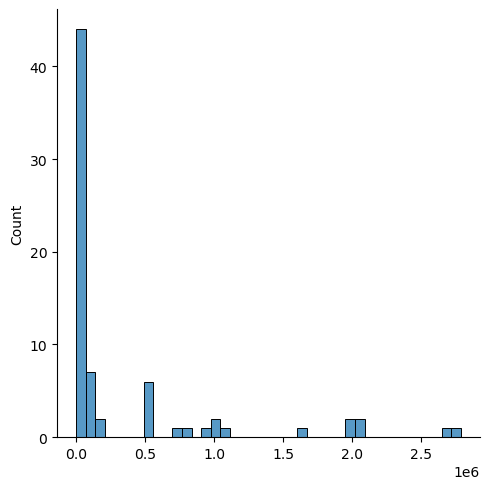

In [17]:
x = df_firms.loc[:,"capital"].values
filtered = x[~is_outlier(x)]
sns.displot(filtered, bins=40)

In [18]:
df_firms.nsmallest(10,"zeichen")

,name,regricht,regart,regnum,url,label,text,gegenstand,capital,website,zeichen
94,Special-Play GmbH,Hannover,HRB,216859,https://www.abenteuerland-mellendorf.de/,Recreational Facilities and Services,\nHandelsregister B des Abteilung B Nummer der...,Betrieb von Indoorspielanlagen.,25000,"b'<!DOCTYPE html><html lang=""de-DE""><head><met...",31
67,Heinrich Marketing GmbH,München,HRB,243496,https://heinrich-marketing.de/,Marketing and Advertising,\nHandelsregister B des Abteilung B Nummer der...,Betreiben einer Marketing und Event Agentur.,25500,"b'<!doctype html>\n<html lang=""de-DE"" prefix=""...",44
106,Handy Deutschland GmbH,Hannover,HRB,205850,https://www.handy-deutschland.de/,Telecommunications,\nHandelsregister B des Abteilung B Nummer der...,"Handel mit Telekommunikationsprodukten, Mobilf...",25000,"b'<!DOCTYPE html>\n<html lang=""de"" xmlns:og=""h...",62
65,Boston Consulting Group GmbH,München,HRB,132429,https://www.bcg.com/de-de/,Management Consulting,\nHandelsregister B des Abteilung B Nummer der...,Beratung von Unternehmen und Unternehmensleitu...,500000,"b'<!DOCTYPE html>\n\n<html class=""bsp no-js na...",84
48,HolidayPirates GmbH,Berlin (Charlottenburg),HRB,141365,https://www.urlaubspiraten.de/,"Leisure, Travel & Tourism",\n- Wiedergabe des aktuellen Registerinhalts -...,Der Aufbau und das Betreiben eines redaktionel...,50000,"b'<!doctype html>\n<html lang=""de"" itemscope i...",88
57,SBB Logistics GmbH,Stendal,HRB,110486,https://www.sbb-logistics.de/,Logistics and Supply Chain,\nHandelsregister B des Abteilung B Nummer der...,ist die Durchführung von Transporten mit Fahrz...,50000,"b'<!DOCTYPE html><html lang=""de-DE""><head><met...",93
54,DHL Paket GmbH,Bonn,HRB,19565,https://www.dhl.de/de/privatkunden.html,Logistics and Supply Chain,\nHandelsregister B des Abteilung B Nummer der...,ist das Vermarkten und Erbringen von Logistikl...,25000,"b'\n\n<!DOCTYPE html>\n<html lang=""de"" class=""...",110
30,INTENSE AG,Würzburg,HRB,6792,https://www.intense.de/,Information Technology and Services,\nHandelsregister B des Abteilung B Nummer der...,Erbringung von Dienstleistungen sowie Herstell...,50004,"b'<!DOCTYPE html>\n<html lang=""de-DE"">\n<head>...",115
14,​​​Freudenberg SE,Mannheim,HRB,714579,https://www.freudenberg.com/de/,Consumer Goods,\nHandelsregister B des Abteilung B Nummer der...,"Industrie-, Handels- und Dienstleistungsgeschä...",450000000,"b'<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\...",119
105,powwow GmbH,Köln,HRB,64068,https://powwow.de/,Telecommunications,\nHandelsregister B des Abteilung B Nummer der...,der Vertrieb von und der Handel mit Telekommun...,777760,b'<html>\r\n<head><title>403 Forbidden</title>...,120


## Korrelation

In [19]:
# Korrelation zwischen capital und zeichen, quasi nicht vorhanden
print(df_firms['capital'].corr(df_firms['zeichen']))

0.051501626252478325


In [20]:
import matplotlib.pyplot as plt
df_plot = df_firms[["capital", "zeichen"]].copy()

df_plot.corr().style.background_gradient(cmap="Greys")



,capital,zeichen
capital,1.000000,0.051502
zeichen,0.051502,1.000000


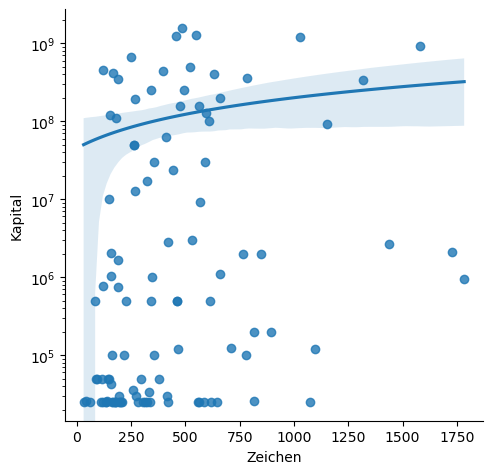

In [21]:
import seaborn as sns
import numpy as np
from scipy import stats

x = "zeichen"
y = "capital"
data = df_plot
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

# sns.scatterplot(x=x, y=y, data=data)
# ax = sns.scatterplot(x=x, y=y, data=data)

ax = sns.lmplot(x=x, y=y, data=data)
ax.set(yscale="log")

# ax.set_title("Zeichen vs. Capital")
# ax.set_xlabel("Kapital")

plt.xlabel("Zeichen")
plt.ylabel("Kapital")

plt.savefig("correl_zeichen_capital_log.svg")

## Histogram
Boxplot macht kein Sinn
Zeige besser ein Histogram mit median mean mode für Zeichen und Kapital

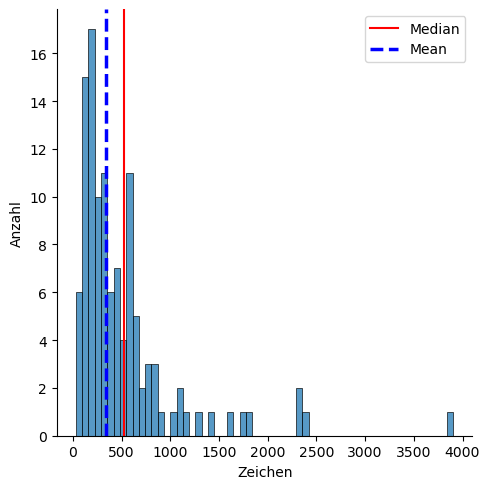

In [22]:
# Verteilung der Anzahl Zeichen
df_firms["zeichen"] = df_firms["gegenstand"].apply(lambda row: len(row))
sns.displot(df_firms, x="zeichen", bins=60)

plt.axvline(x=df_firms.zeichen.mean(),
            color='red')

plt.axvline(x=df_firms.zeichen.median(),
            color='blue',
            ls='--', 
            lw=2.5)

plt.legend(["Median", "Mean"])

plt.xlabel("Zeichen")
plt.ylabel("Anzahl")

plt.savefig("histogramm_zeichen.svg")

## Wordcloud

Wird jetzt im Colab NB gemacht, da dort alle Daten vorhanden sind.

In [24]:
# LABEL = 'Information Technology and Services' #@param ['Mechanical or Industrial Engineering', 'Telecommunications', 'Logistics and Supply Chain', 'Renewables & Environment', 'Information Technology and Services', 'Financial Services', 'Marketing and Advertising', 'datasumer Goods', 'Management datasulting', 'Human Resources', 'Automotive', 'datastruction', 'Recreational Facilities and Services', 'Insurance', 'Real Estate', 'Medical Practice', 'Leisure, Travel & Tourism', 'Legal Services', 'Wholesale']
# MAX_WORDS = 200 #@param {type:'slider', min:10, max:500, step:10}

# # word_list = df_firms[df_firms.label == LABEL]['gegenstand'].tolist()
# word_list = df_firms['gegenstand'].tolist()
# # flat_list = [item for sublist in word_list for item in sublist]
# word_list = ' '.join(word_list)
# wordcloud = WordCloud(background_color='white', max_words=MAX_WORDS, datatour_width=3, datatour_color='steelblue')
# wordcloud.generate_from_text(word_list)
# wordcloud.to_image()

In [25]:
# wordcloud_svg = wordcloud.to_svg(embed_font=True)
# f = open("wordcloud_raw.svg","w+")
# f.write(wordcloud_svg )
# f.close()

## Displacy

In [26]:
# https://www.numpyninja.com/post/nlp-text-data-visualization

In [27]:
# what spacy for ger text displacy? de_core_news_sm?

nlp = spacy.load('en_core_web_sm')
doc = nlp(u'The Handelsregister is a promising source, which is not easy to scrape.')
displacy.render(doc, style='dep')


# Update DB

In [30]:
DB_CONNECT = 'C:/Users/lange/OneDrive/Dokumente/Studium/06_Abschlussarbeiten/Seminar/03_Data/hareg.db'
engine = sqlite3.connect(DB_CONNECT)
### df_firms.to_sql('df_firms', data=engine, if_exists='replace', index = False, chunksize=10000)

In [31]:
# Testen
sql = '''SELECT* FROM df_firms'''
df = pd.read_sql(sql, engine)
df

,name,regricht,regart,regnum,url,label,text,gegenstand,capital,website,zeichen
0,AUDI AG,Ingolstadt,HRB,1,https://www.audi.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,"Entwicklung, Herstellung und Vertrieb von Kraf...","110080000,00","b'<!DOCTYPE html>\n<html lang=""de"" class=""nm-c...",179
1,Volkswagen AG,Wolfsburg,HRB,100484,https://www.volkswagen.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Gegenstand des Unternehmens ist die Herstellun...,"1283315873,28","b'\n\n\n\n<!DOCTYPE html>\n<html lang=""de"" dir...",551
2,ŠKODA AUTO Deutschland GmbH,Darmstadt,HRB,5242,https://www.skoda-auto.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Ist der Import und der Vertrieb von Fahrzeugen...,"2045200,00","b'<!DOCTYPE html>\n<html dir=""ltr"" lang=""de-D...",155
3,Tesla Germany GmbH,Berlin (Charlottenburg),HRB,235261,https://www.tesla.com/de_de/,Automotive,\n- Wiedergabe des aktuellen Registerinhalts -...,"Herstellung, Import, Vertrieb, Verkauf, Wartun...","25000,00","b'<!DOCTYPE html><html lang=""de-DE"" dir=""ltr"" ...",1074
4,BMW AG,München,HRB,42243,https://www.bmw.de/,Automotive,\nHandelsregister B des Abteilung B Nummer der...,Herstellung und Vertrieb von Motoren und damit...,"661399500,00","b'<!DOCTYPE HTML><html lang=""de-DE"" dir=""ltr"" ...",248
...,...,...,...,...,...,...,...,...,...,...,...
109,METRO AG,Düsseldorf,HRB,79055,https://www.metroag.de/de,Wholesale,\nHandelsregister B des Abteilung B Nummer der...,Die Leitung und Förderung von Handels- und Die...,"363097253,00","b'\xef\xbb\xbf<!DOCTYPE html>\r\n<html xmlns=""...",785
110,BayWa AG,München,HRB,4921,https://www.baywa.com/,Wholesale,\nHandelsregister B des Abteilung B Nummer der...,Die Gesellschaft leitet eine internationale Un...,"91807715,84","b'<!doctype html>\n\n\n\n\n\n\n\n<html lang=""d...",1151
111,Brenntag GmbH,Duisburg,HRB,8894,https://www.brenntag.com/de-de/,Wholesale,\nHandelsregister B des Abteilung B Nummer der...,der Handel mit chemischen Erzeugnissen aller A...,"3000000,00",b'<!doctype html>\n<html data-n-head-ssr lang=...,528
112,Klöckner & Co SE,Duisburg,HRB,20486,https://www.kloeckner.com/de,Wholesale,\nHandelsregister B des Abteilung B Nummer der...,Gegenstand des Unternehmens ist (a) die Distri...,"249375000,00","b'<!doctype html>\n<html lang=""de"">\n<head>\n\...",342
